<h2> Skin Cancer Kaggle challenge </h2>
<p>https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000</p>
<p> Dermatoscopic images from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes. Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc). </p>

In [29]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os

In [9]:
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

In [2]:
!ls archive

HAM10000_images_part_1 hmnist_28_28_L.csv     hmnist_8_8_RGB.csv
HAM10000_images_part_2 hmnist_28_28_RGB.csv
HAM10000_metadata.csv  hmnist_8_8_L.csv


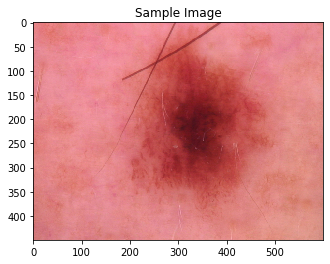

In [3]:
# https://stackoverflow.com/questions/39316447/opencv-giving-wrong-color-to-colored-images-on-loading

img = cv2.imread('archive/HAM10000_images_part_1/ISIC_0024306.jpg')
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.title('Sample Image')
plt.show()

In [23]:
img = resize(RGB_img, (RGB_img.shape[0] // 8, RGB_img.shape[1] // 8),
                       anti_aliasing=True)

(112, 150, 3)


In [25]:
print(img.shape)

(56, 75, 3)


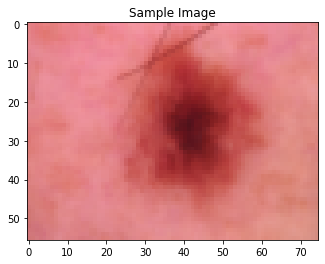

In [26]:
# RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('Sample Image')
plt.show()

In [4]:
df = pd.read_csv("archive/HAM10000_metadata.csv")

In [5]:
df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

<p>More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (followup), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesionid-column within the HAM10000_metadata file.</p>

In [6]:
df.head(1)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp


<p>Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).</p>

In [7]:
# labels
set(df.dx)

{'akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'}

<p>A simple CNN and linear architecture will be used. There are nuances of dx_type, localization, and sex to later consider. For now the dataset will be split with even distribution with respect to the primary label of dx</p>

<p>A function will be needed to map the images with the corresponding row of the metadata file</p>

<h3> Add images to df </h3>
<p>Add images to df and pickle to file df_with_images.pkl. <b><i>Skip</i></b> if this file has already been created.</p>

<h3> Normalize pixels between 0 and 1 </h3>
<p> Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. As such it is good practice to normalize the pixel values so that each pixel value has a value between 0 and 1. </p>

In [27]:
def map_meta_csv_and_img(df, images_dir="archive"):
    """
    Given the HAM10000_metadata.csv, maps the corresponding image array to the row
    Also scale and normalize images. Neural Networks need 0-1 normalized data to converge. 
    The images have been scaled down by a factor of 8 since it is heavy holding so much information.
    This factor can be played around with, scaling less may result in a better model but is computationally
    more expensive.
    """
    images = []
    for i in df['image_id']:
        image_path = os.path.join(f"{images_dir}/HAM10000_images_part_1", f"{i}.jpg")
        if os.path.isfile(image_path):
            img = cv2.imread(image_path)
            RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            RGB_img = resize(RGB_img, (RGB_img.shape[0] // 8, RGB_img.shape[1] // 8), anti_aliasing=True)
            # scale down
            images.append(RGB_img)
        else:
            image_path = os.path.join(f"{images_dir}/HAM10000_images_part_2", f"{i}.jpg")
            # scale down
            if os.path.isfile(image_path):
                img = cv2.imread(image_path)
                RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                RGB_img = resize(RGB_img, (RGB_img.shape[0] // 8, RGB_img.shape[1] // 8), anti_aliasing=True)
                images.append(RGB_img)
            else:
                print("image not found")
                images.append([])
    df["images"] = images
    return df

In [30]:
%%time

df = map_meta_csv_and_img(df)

CPU times: user 13min 13s, sys: 1min 36s, total: 14min 50s
Wall time: 5min 1s


In [31]:
df.head(1)

,lesion_id,image_id,dx,dx_type,age,sex,localization,images
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,"[[[0.7440826330532216, 0.5891806722689079, 0.7..."


In [32]:
%%time

df.to_pickle("df_with_images.pkl")

CPU times: user 796 ms, sys: 1.44 s, total: 2.24 s
Wall time: 2.28 s


<h3> Load df </h3>
<p> load df df_with_images.pkl if the df has not been prepared </p>

In [2]:
df = pd.read_pickle("df_with_images.pkl")

In [34]:
df['images'] / 255

0        [[[0.002917971110012634, 0.002310512440270227,...
1        [[[0.0003383314109957709, 0.000184544405997693...
2        [[[0.002841077607513595, 0.001968473663975394,...
3        [[[0.0003653814466963247, 0.000169165705497885...
4        [[[0.0021302246388751563, 0.001453561816883615...
                               ...                        
10010    [[[0.0025277365848299952, 0.002250919975833456...
10011    [[[7.689350249903884e-05, 8.856483769978488e-0...
10012    [[[0.0018035645630801313, 0.001642088207832149...
10013    [[[0.002429834678969627, 0.001868512110726644,...
10014    [[[0.002691272587466359, 0.002191190201570827,...
Name: images, Length: 10015, dtype: object

<h2>Display images with labels</h2>

In [35]:
labels = list(set(df['dx']))

In [36]:
from collections import Counter

In [37]:
Counter(df['dx'])

Counter({'bkl': 1099,
         'nv': 6705,
         'df': 115,
         'mel': 1113,
         'vasc': 142,
         'bcc': 514,
         'akiec': 327})

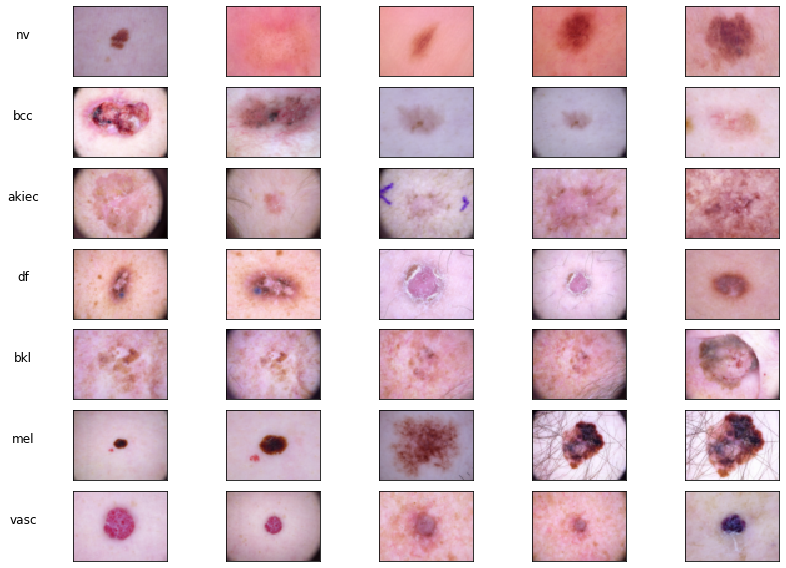

In [39]:
# https://stackoverflow.com/questions/41793931/plotting-images-side-by-side-using-matplotlib
rows = ['{}'.format(row) for row in labels]

fig, axes = plt.subplots(nrows=len(labels), ncols=5, figsize=(12, 8))

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large',labelpad=50)

for idx, label in enumerate(labels):
    for j in range(0, 5):
        image_array = df[df['dx']==label].iloc[j]['images']
        axes[idx,j].imshow(image_array)
        axes[idx, j].tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
            left=False,
            labelleft=False,
            labelright=False,
            labeltop=False,
    labelbottom=False) # labels along the bottom edge are off

        #plt.axis('off')
fig.tight_layout()
plt.show()

<h2>Prepare Training and Testing set</h2>
<p>Split dataset 70% training samples and 30% test samples</p>

<p>To test if the nn architecture converges test with 100 samples. Remember to normalize image array. One hot encode labels</p>

In [40]:
from sklearn.model_selection import train_test_split
import numpy as np

In [42]:
images = np.array(list(df['images']))
labels = np.array(df['dx'])

In [43]:
images.shape

(10015, 56, 75, 3)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(images, np.array(labels), test_size=0.30, random_state=42, stratify=list(np.array(labels)))

<h3>Save training and testing data before processing</h3>

In [45]:
np.save("train", X_train)
np.save("test", X_test)
np.save("train-labels", y_train)
np.save("test-labels", y_test)

<h3>Load Here</h3>

In [5]:
X_train = np.load("train.npy", allow_pickle=True)
X_test = np.load("test.npy", allow_pickle=True)
y_train = np.load("train-labels.npy", allow_pickle=True)
y_test = np.load("test-labels.npy", allow_pickle=True)

In [50]:
# 450, 600, 3
min(X_train.flatten())

0.0

<h2> Build Simple linear Network </h2>
<p></p>

<h2> Build CNN linear Network combo </h2>
<p></p>